# Icentia11k Preprocessing

> Preprocessing steps for Icentia11k data for use in a multi-task classifier

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, TimeSeriesSplit, train_test_split

In [3]:
plt.style.use("seaborn-v0_8-paper")

In [4]:
data = np.load(Path("../data/icentia11k/data.npz"))
data

NpzFile '../data/icentia11k/data.npz' with keys: signal, frame_num, beat, rhythm, patient...

## Missingness

Missing samples in a frame could cause issues in for our classifer, so we should check for that.
A quick check reveals there are no missing data in the inputs or the target labels.

In [5]:
def check_missingness_in_ecg_data(data: dict[str, npt.NDArray]) -> dict[str, float]:
    """Checks for missing data in ECG data. Returns a list of indices where there are missing data"""
    return {
        "signal": np.argwhere(np.isnan(data["signal"])),
        "rhythm": np.argwhere(np.isnan(data["rhythm"])),
        "beat": np.argwhere(np.isnan(data["beat"]))
    }

check_missingness_in_ecg_data(data)

{'signal': array([], shape=(0, 2), dtype=int64),
 'rhythm': array([], shape=(0, 1), dtype=int64),
 'beat': array([], shape=(0, 1), dtype=int64)}

## Train/Test Splits

In a nutshell, we want to design a model that will predict two different tasks: 1) identifying beat abnormalities and 2) identifying rhythm abnormalities.

We have good reason to believe there is some shared underlying structure between the two tasks because they both involve aspects of the same underlying ECG signal.

For a multi-task model, we want two different, but related, datasets:
1. Input ECG Signal, Beat labels
2. Input ECG Signal, Rhythm labels

but we want to make sure that the the input frames from one patient don't end up in both train and test because that might leak information the model wouldn't have access to.

To decide if we stratify-group-split by beat labels or by rhythm labels we should know which aspect would benefit more from the stratification. Because abnormal rhythm class is more rare, we should stratify by that to increase the chance that there is some abnormal rhythm examples in the test.

In [6]:
def make_ecg_data_train_test_split(data: dict[str, npt.NDArray], test_size: float, random_state: int) -> dict[str, npt.NDArray]:
    """Makes a train/test split for ECG data, but stratified by abnormal classes and grouped by patient.
    
    To prevent data leakage, we must ensure data from the same patient is not present in both train and test.
    Thus, we group all ECG frames belonging to a patient together in the same split.
    
    To ensure the presence of normal and abnormal classes in the training set,
        we stratify by class. Specifically, we stratify by the rhythm class because it is rare,
        then select the corresponding beat labels corresponding to the same input signal.
    """
    # Scikit-Learn has no StratifyGroupShuffleSplit class,
    #   however we can approximate the desired behaviour using a similar KFold class
    cv = StratifiedGroupKFold(n_splits=int(1/test_size), shuffle=True,
        random_state=random_state)

    # We stratify split by rhythm to ensure there is an example of abnormal rhythm in the training set.
    #   Abnormal rhythms are more rare than abnormal beats, so we prioritize stratifying by rhythm.
    # We choose not to also stratify by beats because any beat examples we choose should correspond
    #   to input ECG frames that have already been selected for the training set when stratifying by rhythm.
    train_idxs, test_idxs = next(cv.split(data["signal"], data["rhythm"], groups=data["patient"]))

    return {
        "X_train": data["signal"][train_idxs],
        "X_test": data["signal"][test_idxs],
        "rhythm_y_train": data["rhythm"][train_idxs],
        "rhythm_y_test": data["rhythm"][test_idxs],
        "beat_y_train": data["beat"][train_idxs],
        "beat_y_test": data["beat"][test_idxs],
    }

splits = make_ecg_data_train_test_split(data, test_size=0.3, random_state=42)

## Addressing Class Imbalances

First, let's inspect the class imbalances in the training and test sets

In [7]:
def print_ecg_class_distribution(splits: dict[str, npt.NDArray]) -> None:
    """Prints the distribution of ECG classes (abnormal/normal beat/rhythm)"""

    print("Training Set", splits["X_train"].shape)
    beat_train, rhythm_train = splits['beat_y_train'], splits['rhythm_y_train']
    print(f"{beat_train.sum()}/{len(beat_train)} ({beat_train.sum()/len(beat_train):.4f}) abnormal beats")
    print(f"{rhythm_train.sum()}/{len(rhythm_train)} ({rhythm_train.sum()/len(rhythm_train):.4f}) abnormal rhythms")

    print()

    print("Test Set", splits["X_test"].shape)
    beat_test, rhythm_test = splits['beat_y_test'], splits['rhythm_y_test']
    print(f"{beat_test.sum()}/{len(beat_test)} ({beat_test.sum()/len(beat_test):.4f}) abnormal beats")
    print(f"{rhythm_test.sum()}/{len(rhythm_test)} ({rhythm_test.sum()/len(rhythm_test):.4f}) abnormal rhythms")

print_ecg_class_distribution(splits)

Training Set (31440, 800)
3525/31440 (0.1121) abnormal beats
34/31440 (0.0011) abnormal rhythms

Test Set (15720, 800)
46/15720 (0.0029) abnormal beats
277/15720 (0.0176) abnormal rhythms


There are many strategies to address class imbalances (refer to [Chapter 16 from Applied Predictive Modelling (Kuhn & Johnson, 2013)](https://vuquangnguyen2016.wordpress.com/wp-content/uploads/2018/03/applied-predictive-modeling-max-kuhn-kjell-johnson_1518.pdf))




Given the heavy class imbalance in the training set, it is appropriate to oversample.
But remember NOT to oversample in the test set!

Oversampling - [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)



## Visualizing the Data

As we apply preprocessing steps, it's important to visualize transformations of the signals.

Importantly, let's be sure to only inspect the training data.

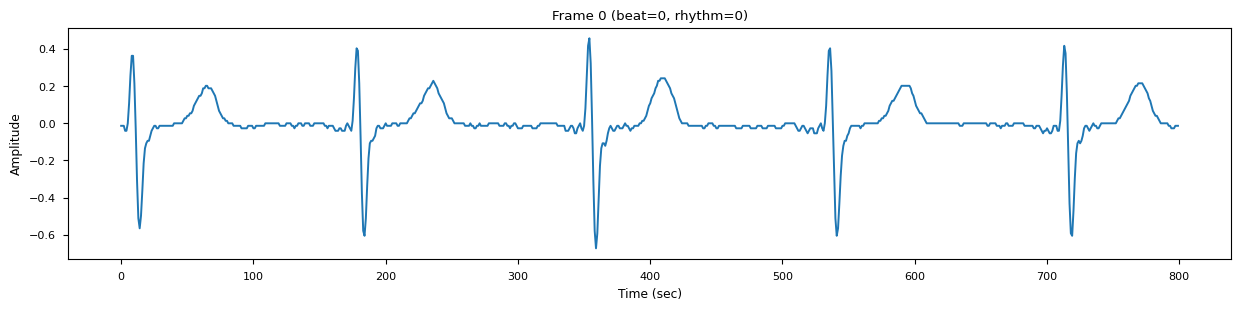

In [8]:
def plot_ecg(data: dict[str, npt.NDArray], frame_id: int) -> plt.Axes:
    frame = data["X_train"][frame_id]
    rhythm = int(data["rhythm_y_train"][frame_id])
    beat = int(data["beat_y_train"][frame_id])
    time = np.arange(len(frame))

    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(time, frame)
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"Frame {frame_id} ({beat=}, {rhythm=})")
    return ax

# Example of frame with normal beat and rhythm
plot_ecg(splits, frame_id=0);

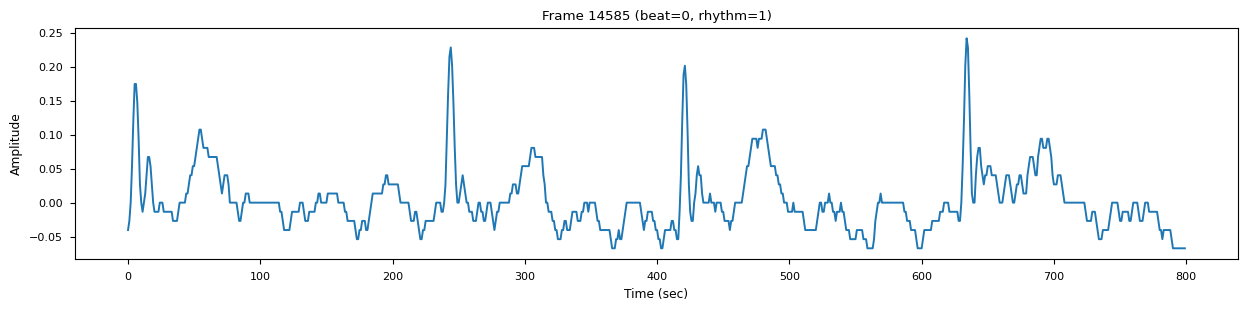

In [9]:
# Example of frame with abnormal rhythm
plot_ecg(splits, frame_id=np.argwhere(splits["rhythm_y_train"] == 1)[0][0]);

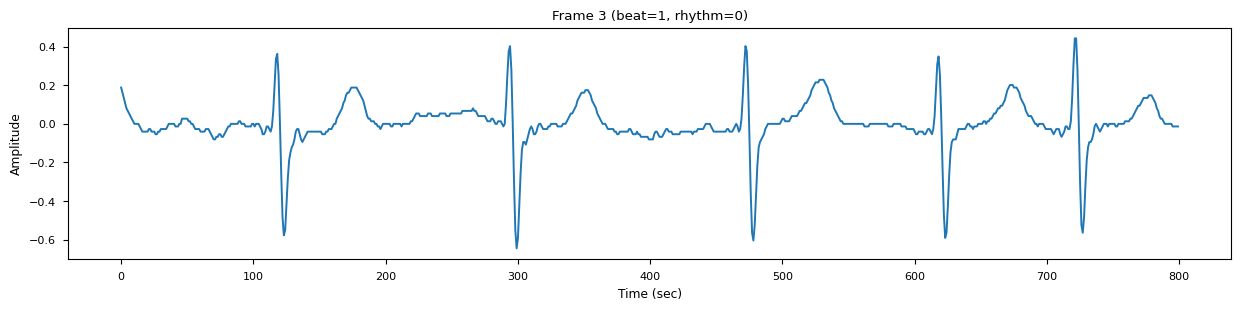

In [10]:
# Example of frame with abnormal beat
plot_ecg(splits, frame_id=np.argwhere(splits["beat_y_train"] == 1)[0][0]);

## Signal Pre-Processing

Based on the visuals above, it appears we should apply a few key preprocessing steps

1. Bandpass filter
2. Normalize
3. 


More information here:

1. [Salimi et al. 2023](https://arxiv.org/pdf/2311.04229)
2. [https://www.dspguide.com/](https://www.dspguide.com/)

In [55]:
from sklearn.preprocessing import normalize

In [58]:
normalized_splits = {
    "X_train": normalize(splits["X_train"], axis=1),
    "rhythm_y_train": splits["rhythm_y_train"],
    "beat_y_train": splits["beat_y_train"],
}

plot_ecg(normalized_splits, frame_id=0);

: 

### Smoothing

## Cross-Validation

We must ensure that when performing cross-validation, we group by patient and stratify by class and preserve the temporal order of frames.

In other words, if we have $N$ patients in the training set, we train our model on $k$ patients and validate on $N - k$ patients, while ensuring the 

We (unrealistically) assume that segments of ECG signals are independent. This simplifying assumption is somewhat reasonable as Tan et al. 2019 derived segments by taking a random subset of ECG recording slices. We assume the segments were spaced out enough in time to not be correlated segments that occurred earlier in time.

Other approaches:
- [Mathworks: Classify ECG Signal](https://www.mathworks.com/help/signal/ug/classify-ecg-signals-using-long-short-term-memory-networks.html) - used random shuffling, because they had one 9000-sample long window of ECG signal for each patient. Bc each signal was from different patients, they were not temporally correlated.

## Evaluating Several Different Classifiers

### Implications for Modelling

[Calibrating a classifier - Scikit-Learn](https://scikit-learn.org/stable/modules/calibration.html#calibrating-a-classifier)